In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno
import math

# 데이터 불러오기
- train data, test data를 한 번에 처리하기 위해 하나의 dataframe으로 합침
- train, test 데이터 구분하기 위해 isTest feature 추가 (train: 0, test: 1)
- Timestamp를 정수로 변환하여 Time으로 저장
- 평화님 데이터에서 가져올 column 선택

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16',
}   

TRAIN_DATA_PATH = '/opt/ml/input/data/train_dataset/tuning_train_data.csv'
TEST_DATA_PATH = '/opt/ml/input/data/train_dataset/tuning_test_data.csv'
df_train = pd.read_csv(TRAIN_DATA_PATH, parse_dates=['Timestamp'])
df_test = pd.read_csv(TEST_DATA_PATH, parse_dates=['Timestamp'])

CPU times: user 11.6 s, sys: 1.43 s, total: 13 s
Wall time: 13 s


In [3]:
# train, test 구분 
df_train['isTest'] = [0 for _ in range(len(df_train))]
df_test['isTest'] = [1 for _ in range(len(df_test))]
print(len(df_train), len(df_test))

2266586 260114


In [4]:
# train, test 합친 후 정렬
df = pd.concat([df_train,df_test])
df = df.sort_values(by=['isTest', 'userID', 'Timestamp']).reset_index(drop=True)

In [5]:
# 가져올 column 선택
df = df[['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp', 'KnowledgeTag', 
         'Category', 'Number', 'item', 'item_order', 'test_size', 'retest', 'user_test_ans_cnt', 'isTest']]

In [6]:
df.dtypes

userID                        int64
assessmentItemID             object
testId                       object
answerCode                    int64
Timestamp            datetime64[ns]
KnowledgeTag                  int64
Category                      int64
Number                       object
item                          int64
item_order                    int64
test_size                     int64
retest                        int64
user_test_ans_cnt             int64
isTest                        int64
dtype: object

In [7]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,test_size,retest,user_test_ans_cnt,isTest
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,0,0,6,0,0,0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1,1,6,0,1,0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,2,2,6,0,2,0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,3,3,6,0,3,0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,4,4,6,0,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,0,0,5,0,0,1
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1,1,5,0,1,1
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,2,2,5,0,2,1
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,3,3,5,0,3,1


# Train & Test 데이터 확인
- 사용자: train 6698명, test 744명, 겹치는 사용자 없음
- 문제: train 9454개, test 9454개, 모두 겹침
- 예측해야 하는 문제들: 444개

## 사용자

In [8]:
df.groupby(['userID', 'isTest']).agg({'answerCode': 'mean'})

,,answerCode
userID,isTest,
0,0,0.630872
1,0,0.853162
2,0,0.612319
3,1,0.691120
4,1,0.691505
...,...,...
7437,0,0.375000
7438,0,0.750000
7439,1,0.625000


In [9]:
# train 데이터에 포함된 user들
user_train_groupby = df[df['isTest']==0].groupby('userID').agg({'answerCode': 'mean'})
user_train_groupby.index

Int64Index([   0,    1,    2,    5,    6,    7,    8,    9,   10,   11,
            ...
            7431, 7432, 7433, 7434, 7435, 7436, 7437, 7438, 7440, 7441],
           dtype='int64', name='userID', length=6698)

In [10]:
# test 데이터에 포함된 user들
user_test_groupby = df[df['isTest']==1].groupby('userID').agg({'answerCode': 'mean'})
user_test_groupby.index

Int64Index([   3,    4,   13,   17,   26,   29,   45,   53,   58,   64,
            ...
            7368, 7369, 7373, 7382, 7392, 7395, 7404, 7416, 7417, 7439],
           dtype='int64', name='userID', length=744)

In [11]:
# 겹치는 user 수 확인
s1 = set(user_train_groupby.index)
s2 = set(user_test_groupby.index)
print(len(s1), len(s2), len(s1 & s2))

6698 744 0


## 문제

In [12]:
df.groupby(['assessmentItemID', 'isTest']).agg({'answerCode': 'mean'})

answerCode
assessmentItemID isTest            
A010001001       0         0.930599
                 1         0.848485
A010001002       0         0.958991
                 1         0.969697
A010001003       0         0.905363
...                             ...
A090074004       1         0.600000
A090074005       0         0.400000
                 1         0.400000
A090074006       0         0.466667
                 1        -0.600000

[18908 rows x 1 columns]

In [13]:
# train 데이터에 포함된 문제들
prob_train_groupby = df[df['isTest']==0].groupby('assessmentItemID').agg({'answerCode': 'mean'})
prob_train_groupby.index

Index(['A010001001', 'A010001002', 'A010001003', 'A010001004', 'A010001005',
       'A010002001', 'A010002002', 'A010002003', 'A010002004', 'A010002005',
       ...
       'A090073003', 'A090073004', 'A090073005', 'A090073006', 'A090074001',
       'A090074002', 'A090074003', 'A090074004', 'A090074005', 'A090074006'],
      dtype='object', name='assessmentItemID', length=9454)

In [14]:
# test 데이터에 포함된 문제들
prob_test_groupby = df[df['isTest']==1].groupby('assessmentItemID').agg({'answerCode': 'mean'})
prob_test_groupby.index

Index(['A010001001', 'A010001002', 'A010001003', 'A010001004', 'A010001005',
       'A010002001', 'A010002002', 'A010002003', 'A010002004', 'A010002005',
       ...
       'A090073003', 'A090073004', 'A090073005', 'A090073006', 'A090074001',
       'A090074002', 'A090074003', 'A090074004', 'A090074005', 'A090074006'],
      dtype='object', name='assessmentItemID', length=9454)

In [15]:
# 겹치는 문제 수 확인
s1 = set(prob_train_groupby.index)
s2 = set(prob_test_groupby.index)
print(len(s1), len(s2), len(s1 & s2))

9454 9454 9454


In [16]:
# 예측해야 하는 문제들
pred_prob_list = df[df['answerCode']==-1].groupby('assessmentItemID').agg({'answerCode': 'sum'}).index.tolist()
len(pred_prob_list)

444

## 시험지

In [17]:
df.groupby('testId').agg({'answerCode': 'mean'})

,answerCode
testId,
A010000001,0.923429
A010000002,0.931429
A010000003,0.842857
A010000004,0.880571
A010000005,0.849143
...,...
A090000070,0.457500
A090000071,0.345000
A090000072,0.453333


## 태그

In [18]:
df.groupby('KnowledgeTag').agg({'answerCode': 'mean'})

,answerCode
KnowledgeTag,
23,0.593000
24,0.625000
25,0.850000
26,0.610741
30,0.530000
...,...
11253,0.731875
11265,0.674000
11269,0.558519


# Timestamp 관련 feature
- Time: Timestamp를 정수로 변환
- elapsed_time: 이전 문제 푼 시점로부터 경과한 시간(문제 푸는데 걸린 시간), 1시간이 넘는 outlier들은 해당 문제의 중앙값으로 대체
- prob_mean_time: 문항별 평균 풀이 시간
- user_time_sum, user_time_mean: 사용자별 누적 소요 시간, 평균 누적 소요 시간
- moving_average_time: 최근 3문제 평균 풀이 시간
- user_test_time_sum: 사용자가 해당 시험지의 문제를 푼 누적 시간
- hour, weekday: 시간대, 요일

In [19]:
df1 = df.copy()

## Time

In [20]:
# Timestamp를 정수로 변환
df1['Time'] = df1['Timestamp'].transform(lambda x: int(x.strftime('%s')))

## elapsed_time

In [21]:
df1['elapsed_time'] = df1.loc[:, ['userID', 'Time']].groupby('userID').diff().shift(-1).fillna(-1) # 각 사용자의 마지막 값은 -1로 채움
df1.head(20)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,test_size,retest,user_test_ans_cnt,isTest,Time,elapsed_time
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,0,0,6,0,0,0,1585009031,3.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1,1,6,0,1,0,1585009034,8.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,2,2,6,0,2,0,1585009042,7.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,3,3,6,0,3,0,1585009049,7.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,4,4,6,0,4,0,1585009056,11.0
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,6,A001007,6,5,6,0,5,0,1585009067,192856.0
6,0,A060003001,A060000003,0,2020-03-26 05:52:03,7226,6,A003001,0,0,7,0,0,0,1585201923,7.0
7,0,A060003002,A060000003,1,2020-03-26 05:52:10,7226,6,A003002,1,1,7,0,1,0,1585201930,64.0
8,0,A060003003,A060000003,1,2020-03-26 05:53:14,7226,6,A003003,2,2,7,0,2,0,1585201994,15.0
9,0,A060003004,A060000003,1,2020-03-26 05:53:29,7226,6,A003004,3,3,7,0,3,0,1585202009,19.0


In [22]:
df1['elapsed_time'].describe()

count    2.526700e+06
mean     5.263962e+04
std      4.053399e+05
min     -1.000000e+00
25%      1.300000e+01
50%      3.700000e+01
75%      1.350000e+02
max      2.560230e+07
Name: elapsed_time, dtype: float64

In [23]:
df1[df1['userID']==0]['elapsed_time']

0       3.0
1       8.0
2       7.0
3       7.0
4      11.0
       ... 
740    86.0
741    83.0
742    91.0
743     5.0
744    -1.0
Name: elapsed_time, Length: 745, dtype: float64

<AxesSubplot:>

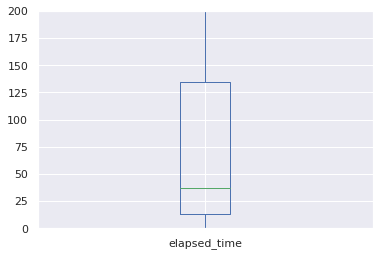

In [24]:
df1['elapsed_time'].plot.box(ylim=[0,200])

## elapsed_time outlier를 해당 문제의 중앙값으로 대체

In [25]:
# outlier 기준 시간: 1시간
T = 3600

In [26]:
# outlier 비율 확인
df1_1 = df1.copy()
df1_1['elapsed_time_cut'] = np.digitize(df1['elapsed_time'], bins=[T])
elapsed_time_groupby = df1_1.groupby('elapsed_time_cut').agg({'userID': 'count'})
elapsed_time_groupby.index.name = 'elapsed_time_cut'
elapsed_time_groupby.reset_index(inplace=True)
elapsed_time_groupby

,elapsed_time_cut,userID
0,0,2164685
1,1,362015


<AxesSubplot:ylabel='userID'>

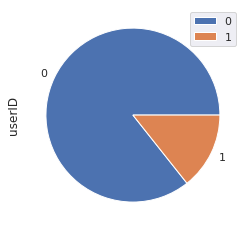

In [27]:
elapsed_time_groupby.plot.pie(x='elapsed_time_cate', y='userID')

In [28]:
print(len(df1[df1['elapsed_time'] <= T]), len(df1[df1['elapsed_time'] > T]))

2164694 362006


In [29]:
df1.groupby('assessmentItemID').agg({'elapsed_time':'median'}).head(20)

,elapsed_time
assessmentItemID,
A010001001,18.0
A010001002,12.0
A010001003,28.0
A010001004,38.0
A010001005,166909.0
A010002001,32.0
A010002002,11.0
A010002003,12.0
A010002004,30.5


In [30]:
df1[(df1['assessmentItemID'] == 'A010001005') & (df1['elapsed_time'] <= 3600)].head(10)

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,test_size,retest,user_test_ans_cnt,isTest,Time,elapsed_time
171577,230,A010001005,A010000001,1,2020-03-31 12:40:49,5844,1,A001005,4,4,5,0,4,0,1585658449,3397.0
203435,274,A010001005,A010000001,1,2020-05-15 09:49:21,5844,1,A001005,4,4,5,0,4,0,1589536161,2163.0
293503,398,A010001005,A010000001,1,2020-04-09 02:43:00,5844,1,A001005,4,4,5,0,4,0,1586400180,138.0
297587,403,A010001005,A010000001,1,2020-03-06 01:35:55,5844,1,A001005,4,4,5,0,4,0,1583458555,3435.0
516949,726,A010001005,A010000001,1,2020-03-15 04:15:33,5844,1,A001005,4,4,5,0,4,0,1584245733,1452.0
566876,800,A010001005,A010000001,1,2020-05-30 06:00:01,5844,1,A001005,4,4,5,0,0,0,1590818401,11.0
655837,936,A010001005,A010000001,1,2020-03-31 03:25:10,5844,1,A001005,4,4,5,0,4,0,1585625110,45.0
666961,956,A010001005,A010000001,1,2020-04-08 08:50:29,5844,1,A001005,4,4,5,0,4,0,1586335829,724.0
943744,1399,A010001005,A010000001,1,2020-01-15 12:36:03,5844,1,A001005,4,4,5,0,4,0,1579091763,82.0
951833,1412,A010001005,A010000001,1,2020-03-20 10:45:47,5844,1,A001005,4,4,5,0,4,0,1584701147,1736.0


In [31]:
# outlier 제외하고 중앙값 계산
df1_2 = df1[(df1['elapsed_time'] >= 0) & (df1['elapsed_time'] <= 3600)]
elapsed_time_median_groupby = df1_2.groupby('assessmentItemID').agg({'elapsed_time':'median'})
elapsed_time_median_groupby.head(20)

,elapsed_time
assessmentItemID,
A010001001,18.0
A010001002,12.0
A010001003,28.0
A010001004,38.0
A010001005,153.5
A010002001,32.0
A010002002,11.0
A010002003,12.0
A010002004,30.5


In [32]:
# outlier index 저장
index = ((df1['elapsed_time'] < 0) | (df1['elapsed_time'] > 3600)).tolist()
index2 = df1.loc[index].index
index2

Int64Index([      5,      12,      19,      26,      32,      39,      46,
                 62,      69,      76,
            ...
            2526653, 2526659, 2526664, 2526668, 2526673, 2526679, 2526683,
            2526688, 2526694, 2526699],
           dtype='int64', length=369448)

In [33]:
df1.loc[index]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,test_size,retest,user_test_ans_cnt,isTest,Time,elapsed_time
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,6,A001007,6,5,6,0,5,0,1585009067,192856.0
12,0,A060003007,A060000003,1,2020-03-26 05:54:11,7226,6,A003007,6,6,7,0,6,0,1585202051,428921.0
19,0,A060005007,A060000005,1,2020-03-31 05:05:48,7228,6,A005007,6,6,7,0,6,0,1585631148,172069.0
26,0,A060007007,A060000007,1,2020-04-02 05:04:08,7229,6,A007007,6,6,7,0,6,0,1585803848,329453.0
32,0,A080002006,A080000002,1,2020-04-06 00:38:05,1395,8,A002006,5,5,6,0,5,0,1586133485,90248.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526679,7417,A010107006,A010000107,0,2020-08-24 01:26:11,6648,1,A107006,5,5,6,0,5,1,1598232371,1165321.0
2526683,7417,A050193004,A050000193,-1,2020-09-06 13:09:15,10402,5,A193004,3,3,4,0,3,1,1599397755,-1.0
2526688,7439,A040003005,A040000003,0,2020-01-14 08:39:48,7268,4,A003005,4,4,5,0,4,1,1578991188,19004118.0
2526694,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4,A197006,5,5,6,0,5,1,1597995585,4721258.0


In [34]:
median = elapsed_time_median_groupby.loc[df1.loc[index, 'assessmentItemID']].reset_index()['elapsed_time']
median.index = index2
median

5          476.5
12         186.0
19         307.0
26         175.5
32         124.5
           ...  
2526679    243.0
2526683     97.5
2526688    669.0
2526694    122.0
2526699    237.0
Name: elapsed_time, Length: 369448, dtype: float64

In [35]:
df1.loc[index, 'elapsed_time'] = median
df1.loc[index]

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,test_size,retest,user_test_ans_cnt,isTest,Time,elapsed_time
5,0,A060001007,A060000001,1,2020-03-24 00:17:47,7225,6,A001007,6,5,6,0,5,0,1585009067,476.5
12,0,A060003007,A060000003,1,2020-03-26 05:54:11,7226,6,A003007,6,6,7,0,6,0,1585202051,186.0
19,0,A060005007,A060000005,1,2020-03-31 05:05:48,7228,6,A005007,6,6,7,0,6,0,1585631148,307.0
26,0,A060007007,A060000007,1,2020-04-02 05:04:08,7229,6,A007007,6,6,7,0,6,0,1585803848,175.5
32,0,A080002006,A080000002,1,2020-04-06 00:38:05,1395,8,A002006,5,5,6,0,5,0,1586133485,124.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526679,7417,A010107006,A010000107,0,2020-08-24 01:26:11,6648,1,A107006,5,5,6,0,5,1,1598232371,243.0
2526683,7417,A050193004,A050000193,-1,2020-09-06 13:09:15,10402,5,A193004,3,3,4,0,3,1,1599397755,97.5
2526688,7439,A040003005,A040000003,0,2020-01-14 08:39:48,7268,4,A003005,4,4,5,0,4,1,1578991188,669.0
2526694,7439,A040197006,A040000197,1,2020-08-21 07:39:45,2132,4,A197006,5,5,6,0,5,1,1597995585,122.0


In [36]:
df1['elapsed_time'].describe()

count    2.526700e+06
mean     1.069155e+02
std      2.526388e+02
min      0.000000e+00
25%      1.200000e+01
50%      3.300000e+01
75%      9.900000e+01
max      3.600000e+03
Name: elapsed_time, dtype: float64

In [37]:
elapsed_time_groupby = df1.groupby('elapsed_time').agg({'answerCode': 'mean'})
elapsed_time_groupby.index.name = 'elapsed_time'
elapsed_time_groupby.reset_index(inplace=True)
elapsed_time_groupby

,elapsed_time,answerCode
0,0.0,0.445531
1,1.0,0.258752
2,2.0,0.240455
3,3.0,0.262829
4,3.5,0.363057
...,...,...
3897,3596.0,0.750000
3898,3597.0,0.800000
3899,3598.0,0.500000
3900,3599.0,0.500000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='elapsed_time', ylabel='answerCode'>

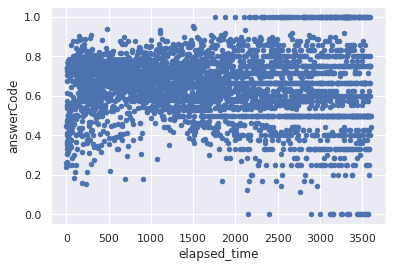

In [38]:
elapsed_time_groupby.plot.scatter(x='elapsed_time', y='answerCode')

## 문항별 평균 소요 시간

In [39]:
# 예측해야 하는 행 제외한 데이터
df1_1 = df1[df1['answerCode'] != -1]
len(df1_1)

2525956

In [40]:
prob_groupby = df1_1.groupby(['assessmentItemID'])['elapsed_time'].agg(['mean'])
prob_groupby.columns = ['prob_mean_time']
prob_groupby

,prob_mean_time
assessmentItemID,
A010001001,27.854286
A010001002,17.311429
A010001003,48.262857
A010001004,55.605714
A010001005,200.940000
...,...
A090074002,45.040000
A090074003,21.000000
A090074004,38.780000


In [41]:
df1 = pd.merge(df1, prob_groupby, on=['assessmentItemID'], how="left")
df1['prob_mean_time']

0           13.660000
1           26.112000
2           19.180000
3           18.076000
4           35.720000
              ...    
2526695     69.930000
2526696     43.843333
2526697     72.900000
2526698     65.680000
2526699    294.026756
Name: prob_mean_time, Length: 2526700, dtype: float64

In [42]:
df1[df1['assessmentItemID']=='A010001001']

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,test_size,retest,user_test_ans_cnt,isTest,Time,elapsed_time,prob_mean_time
4544,8,A010001001,A010000001,1,2020-03-01 08:36:27,5844,1,A001001,0,0,5,0,0,0,1583051787,44.0,27.854286
8111,14,A010001001,A010000001,1,2020-07-10 08:58:07,5844,1,A001001,0,0,5,0,0,0,1594371487,11.0,27.854286
9746,16,A010001001,A010000001,1,2020-03-12 21:46:25,5844,1,A001001,0,0,5,0,0,0,1584049585,48.0,27.854286
11222,18,A010001001,A010000001,1,2020-07-14 12:37:21,5844,1,A001001,0,0,5,0,0,0,1594730241,17.0,27.854286
33368,46,A010001001,A010000001,0,2020-03-18 02:01:40,5844,1,A001001,0,0,5,0,0,0,1584496900,10.0,27.854286
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2492684,3876,A010001001,A010000001,1,2020-03-26 13:24:47,5844,1,A001001,0,0,5,0,0,1,1585229087,38.0,27.854286
2494878,3986,A010001001,A010000001,1,2020-03-27 12:46:12,5844,1,A001001,0,0,5,0,0,1,1585313172,15.0,27.854286
2509052,4819,A010001001,A010000001,1,2020-03-30 04:59:07,5844,1,A001001,0,0,5,0,0,1,1585544347,15.0,27.854286
2511459,5066,A010001001,A010000001,1,2020-04-01 09:02:56,5844,1,A001001,0,0,5,0,0,1,1585731776,18.0,27.854286


## 사용자별 소요시간

In [43]:
df_user = df1.groupby('userID')['answerCode']
df_solTime = df1.groupby('userID')['elapsed_time']

# 누적 소요시간
df1['shift'] = df_solTime.shift().fillna(0)
df1['user_time_sum'] = df1.groupby('userID')['shift'].cumsum()
df1 = df1.drop(columns='shift')


# 누적 평균 소요시간
df1['user_time_mean'] = (df1['user_time_sum'] / df_user.cumcount()).fillna(0)
df1[['user_time_sum', 'user_time_mean']]

,user_time_sum,user_time_mean
0,0.0,0.000000
1,3.0,3.000000
2,11.0,5.500000
3,18.0,6.000000
4,25.0,6.250000
...,...,...
2526695,1162.0,105.636364
2526696,1180.0,98.333333
2526697,1201.0,92.384615
2526698,1290.0,92.142857


## 사용자가 해당 시험지의 문제를 푼 누적 시간 

In [44]:
df1['user_test_time_sum'] = df1.groupby(['userID', 'testId'])['elapsed_time'].cumsum()

## 최근 3문제 평균 풀이 시간

In [45]:
df1['moving_average_time'] = df1.groupby(['userID'])['elapsed_time'].rolling(3).mean().fillna(0).values
df1[['userID', 'elapsed_time', 'moving_average_time']]

,userID,elapsed_time,moving_average_time
0,0,3.0,0.000000
1,0,8.0,0.000000
2,0,7.0,6.000000
3,0,7.0,7.333333
4,0,11.0,8.333333
...,...,...,...
2526695,7439,18.0,153.000000
2526696,7439,21.0,145.333333
2526697,7439,89.0,152.666667
2526698,7439,32.0,43.333333


In [46]:
moving_average_time_groupby = df1.groupby('moving_average_time').agg({'answerCode': 'mean'})
moving_average_time_groupby.index.name = 'moving_average_time'
moving_average_time_groupby.reset_index(inplace=True)
moving_average_time_groupby

,moving_average_time,answerCode
0,0.000000,0.639420
1,0.333333,0.619355
2,0.666667,0.662983
3,1.000000,0.637975
4,1.333333,0.644632
...,...,...
8012,2416.000000,1.000000
8013,2444.000000,1.000000
8014,2444.666667,1.000000
8015,2750.666667,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='moving_average_time', ylabel='answerCode'>

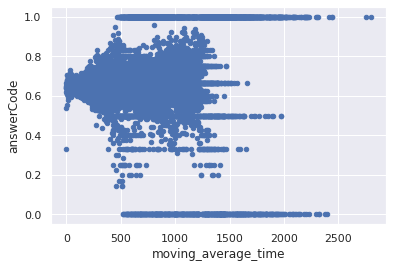

In [47]:
moving_average_time_groupby.plot.scatter(x='moving_average_time', y='answerCode')

## 시간대 & 요일

In [48]:
df1['hour'] = df1['Timestamp'].transform(lambda x: pd.to_datetime(x).dt.hour)
df1['weekday'] = df1['Timestamp'].transform(lambda x: pd.to_datetime(x).dt.weekday)

In [49]:
hour_groupby = df1.groupby('hour').agg({'answerCode': 'mean'})
hour_groupby.index.name = 'hour'
hour_groupby.reset_index(inplace=True)
hour_groupby

,hour,answerCode
0,0,0.650462
1,1,0.644876
2,2,0.642090
3,3,0.633329
4,4,0.633352
5,5,0.624684
6,6,0.628330
7,7,0.641452
8,8,0.669495
9,9,0.682831


<AxesSubplot:xlabel='hour'>

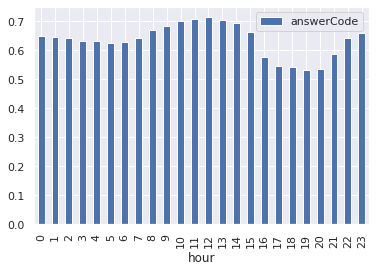

In [50]:
hour_groupby.plot.bar(x='hour', y='answerCode')

In [51]:
weekday_groupby = df1.groupby('weekday').agg({'answerCode': 'mean'})
weekday_groupby.index.name = 'weekday'
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
weekday_groupby['weekday_name'] = days
weekday_groupby.reset_index(inplace=True)
weekday_groupby.head(24)

,weekday,answerCode,weekday_name
0,0,0.675781,Mon
1,1,0.667045,Tue
2,2,0.641120,Wed
3,3,0.657922,Thu
4,4,0.643650,Fri
5,5,0.603369,Sat
6,6,0.674146,Sun


<AxesSubplot:xlabel='weekday_name'>

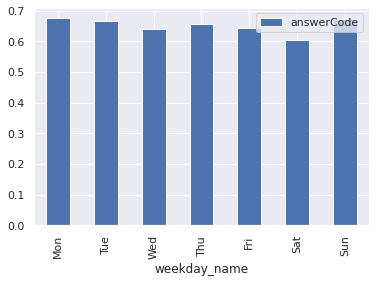

In [52]:
weekday_groupby.plot.bar(x='weekday_name', y='answerCode')

In [53]:
df1

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,...,isTest,Time,elapsed_time,prob_mean_time,user_time_sum,user_time_mean,user_test_time_sum,moving_average_time,hour,weekday
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,0,0,...,0,1585009031,3.0,13.660000,0.0,0.000000,3.0,0.000000,0,1
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1,1,...,0,1585009034,8.0,26.112000,3.0,3.000000,11.0,0.000000,0,1
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,2,2,...,0,1585009042,7.0,19.180000,11.0,5.500000,18.0,6.000000,0,1
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,3,3,...,0,1585009049,7.0,18.076000,18.0,6.000000,25.0,7.333333,0,1
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,4,4,...,0,1585009056,11.0,35.720000,25.0,6.250000,36.0,8.333333,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,0,0,...,1,1602716843,18.0,69.930000,1162.0,105.636364,18.0,153.000000,23,2
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1,1,...,1,1602716861,21.0,43.843333,1180.0,98.333333,39.0,145.333333,23,2
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,2,2,...,1,1602716882,89.0,72.900000,1201.0,92.384615,128.0,152.666667,23,2
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,3,3,...,1,1602716971,32.0,65.680000,1290.0,92.142857,160.0,43.333333,23,2


# 총 개수 & 맞춘 개수 & 정답률
- 문항, 시험지, 태그별 feature들은 난이도를 파악하기 위한 것이므로 전체 데이터로 계산
- 사용자와 관련된 feature들은 시간에 따른 변화를 반영하기 위해 누적합으로 계산
- Feature 이름 설명
    - 누적
        - past_X_count: 과거에 푼 총 누적 개수
        - past_X_correct: 과거에 맞춘 누적 개수
        - average_X_correct: 누적 정답률 (past_X_correct / past_X_count)
    - 전체
        - X_mean: 평균 정답률
        - X_sum: 총 개수
- 문항별 - 문항의 난이도 파악
    - 누적: past_prob_count, past_prob_correct, average_prob_correct
    - 전체: prob_mean, prob_sum
    - prob_mean_cate: prob_mean 카테고리화 (난이도 레벨)
- 시험지별 - 시험지의 난이도 파악
    - 누적: past_test_count, past_test_correct, average_test_correct
    - 전체: test_mean, test_sum
- 태그별 - 태그의 난이도 파악
    - 누적: past_tag_count, past_tag_correct, average_tag_correct
    - 전체: tag_mean, tag_sum
- 사용자별 - 사용자의 실력 파악
    - 누적: past_user_count, past_user_correct, average_user_correct
    - average_user_correct_cate: average_user_correct 카테고리화 (사용자의 레벨)
    - moving_average_user_correct_10, moving_average_user_correct_5: 사용자의 집중력, 추세를 파악하기 위해 최근 10문제 / 5문제의 정답률 계산
- 사용자 + 문항별 - 사용자가 같은 문제를 반복해서 풀었는지 파악
    - 누적: past_user_prob_count, past_user_prob_correct, past_user_prob_correct
- 사용자 + 시험지별 - 사용자가 해당 시험을 몇 번째 풀었는지 파악
    - 누적: past_user_test_count, past_user_test_correct, average_user_test_correct
- 사용자 + 태그별 - 사용자가 해당 태그에 얼마나 강한지 파악
    - 누적: past_user_tag_count, past_user_tag_correct, average_user_tag_correct

In [54]:
# 비율 계산하는 함수
def percentile(s):
    return np.sum(s) / len(s)

In [55]:
df2 = df1.copy()

In [56]:
# 시간 순서대로 정렬
df2 = df2.sort_values(by=['Timestamp', 'isTest']).reset_index(drop=True)

In [57]:
df2

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,...,isTest,Time,elapsed_time,prob_mean_time,user_time_sum,user_time_mean,user_test_time_sum,moving_average_time,hour,weekday
0,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,6,A014001,0,0,...,0,1577804881,20.0,59.320,0.0,0.000000,20.0,61.333333,15,1
1,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,6,A014002,1,1,...,0,1577804901,34.0,68.280,20.0,20.000000,54.0,59.666667,15,1
2,784,A060014003,A060000014,1,2019-12-31 15:08:55,7229,6,A014003,2,2,...,0,1577804935,18.0,78.304,54.0,27.000000,72.0,64.333333,15,1
3,784,A060014004,A060000014,1,2019-12-31 15:09:13,7229,6,A014004,3,3,...,0,1577804953,16.0,57.140,72.0,24.000000,88.0,26.666667,15,1
4,784,A060014005,A060000014,0,2019-12-31 15:09:29,7229,6,A014005,4,4,...,0,1577804969,1926.0,222.408,88.0,22.000000,2014.0,37.000000,15,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,588,A070152004,A070000152,0,2020-12-29 16:46:08,7866,7,A152004,3,3,...,0,1609260368,5.0,150.290,79039.5,126.665865,54.0,96.333333,16,1
2526696,588,A070152005,A070000152,1,2020-12-29 16:46:13,3288,7,A152005,4,4,...,0,1609260373,2.0,109.730,79044.5,126.471200,56.0,98.666667,16,1
2526697,588,A070152006,A070000152,0,2020-12-29 16:46:15,9078,7,A152006,5,5,...,0,1609260375,3.0,49.670,79046.5,126.272364,59.0,86.666667,16,1
2526698,588,A070152007,A070000152,0,2020-12-29 16:46:18,9080,7,A152007,6,6,...,0,1609260378,3.0,83.750,79049.5,126.075758,62.0,13.000000,16,1


In [58]:
# 예측해야 하는 행 제외한 데이터
df2_1 = df2[df2['answerCode'] != -1]
len(df2_1)

2525956

## 문항별(누적)

In [59]:
df_prob = df2.groupby('assessmentItemID')['answerCode']

# 특정 문항 과거에 푼 횟수
df2['past_prob_count'] = df_prob.cumcount()

# 특정 문항 과거에 맞춘 횟수
df2['shift'] = df_prob.shift().fillna(0)
df2['past_prob_correct'] = df2.groupby('assessmentItemID')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 특정 문항 과거 평균 정답률
df2['average_prob_correct'] = (df2['past_prob_correct'] / df2['past_prob_count']).fillna(0)

In [60]:
prob_groupby = df2.groupby('past_prob_count').agg({
    'answerCode': percentile
})
prob_groupby.index.name = 'past_prob_count'
prob_groupby.reset_index(inplace=True)
prob_groupby.describe()

,past_prob_count,answerCode
count,500.000000,500.000000
mean,249.500000,0.583850
std,144.481833,0.118000
min,0.000000,0.125000
25%,124.750000,0.499259
50%,249.500000,0.641802
75%,374.250000,0.662472
max,499.000000,0.757351


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_prob_count', ylabel='answerCode'>

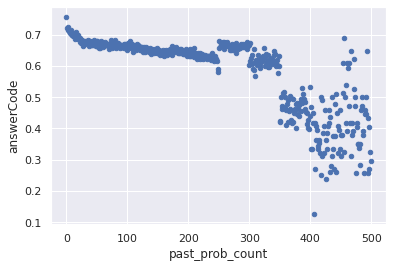

In [61]:
prob_groupby.plot.scatter(x='past_prob_count', y='answerCode')

## 문항별(전체)

In [62]:
# 문항별 전체 정답률
prob_groupby = df1_1.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum'])
prob_groupby.columns = ['prob_mean', 'prob_sum']

In [63]:
df2 = pd.merge(df2, prob_groupby, on=['assessmentItemID'], how="left")

In [64]:
# 카테고리화
df2['prob_mean_cate'] = df2['prob_mean'].transform(lambda x: math.floor(x*10))
df2[['prob_mean','prob_mean_cate']]

,prob_mean,prob_mean_cate
0,0.892,8
1,0.892,8
2,0.340,3
3,0.588,5
4,0.232,2
...,...,...
2526695,0.670,6
2526696,0.600,6
2526697,0.330,3
2526698,0.490,4


## 시험지별(누적)

In [65]:
df_test = df2.groupby('testId')['answerCode']

# 특정 시험지 과거에 푼 횟수
df2['past_test_count'] = df_test.cumcount()

# 특정 시험지 과거에 맞춘 횟수
df2['shift'] = df_test.shift().fillna(0)
df2['past_test_correct'] = df2.groupby('testId')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 특정 시험지 과거 평균 정답률
df2['average_test_correct'] = (df2['past_test_correct'] / df2['past_test_count']).fillna(0)

In [66]:
test_groupby = df2.groupby('past_test_count').agg({
    'answerCode': percentile
})
test_groupby.index.name = 'past_test_count'
test_groupby.reset_index(inplace=True)
test_groupby.describe()

,past_test_count,answerCode
count,4400.000000,4400.000000
mean,2199.500000,0.552078
std,1270.314922,0.196285
min,0.000000,-1.000000
25%,1099.750000,0.462753
50%,2199.500000,0.575702
75%,3299.250000,0.671242
max,4399.000000,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_test_count', ylabel='answerCode'>

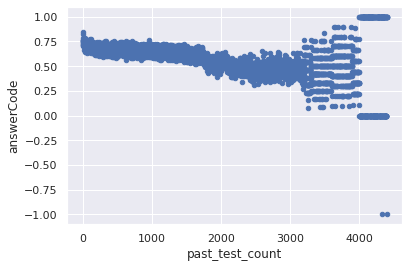

In [67]:
test_groupby.plot.scatter(x='past_test_count', y='answerCode')

## 시험지별(전체)

In [68]:
# 시험지별 전체 정답률
test_groupby = df1_1.groupby(['testId'])['answerCode'].agg(['mean', 'sum'])
test_groupby.columns = ["test_mean", 'test_sum']

In [69]:
df2 = pd.merge(df2, test_groupby, on=['testId'], how="left")

## 태그별(누적)

In [70]:
df_tag = df2.groupby('KnowledgeTag')['answerCode']

# 특정 태그 과거에 푼 횟수
df2['past_tag_count'] = df_tag.cumcount()

# 특정 태그 과거에 맞춘 횟수
df2['shift'] = df_tag.shift().fillna(0)
df2['past_tag_correct'] = df2.groupby('KnowledgeTag')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 특정 태그 과거 평균 정답률
df2['average_tag_correct'] = (df2['past_tag_correct'] / df2['past_tag_count']).fillna(0)

In [71]:
tag_groupby = df2.groupby('past_tag_count').agg({
    'answerCode': percentile
})
tag_groupby.index.name = 'past_tag_count'
tag_groupby.reset_index(inplace=True)
tag_groupby.describe()

,past_tag_count,answerCode
count,14350.000000,14350.000000
mean,7174.500000,0.697500
std,4142.632516,0.211853
min,0.000000,0.000000
25%,3587.250000,0.625000
50%,7174.500000,0.666667
75%,10761.750000,0.783235
max,14349.000000,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_tag_count', ylabel='answerCode'>

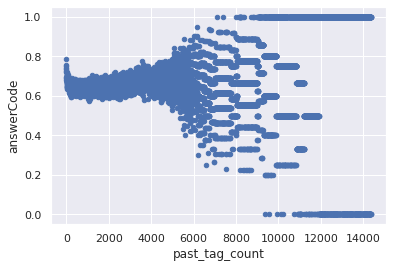

In [72]:
tag_groupby.plot.scatter(x='past_tag_count', y='answerCode')

## 태그별(전체)

In [73]:
# 태그별 전체 정답률
tag_groupby = df1_1.groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum'])
tag_groupby.columns = ["tag_mean", 'tag_sum']

In [74]:
df2 = pd.merge(df2, tag_groupby, on=['KnowledgeTag'], how="left")

## 사용자별

In [75]:
df_user = df2.groupby('userID')['answerCode']

# 과거에 푼 문제 수
df2['past_user_count'] = df_user.cumcount()

# 과거에 맞춘 문제 수
df2['shift'] = df_user.shift().fillna(0)
df2['past_user_correct'] = df2.groupby('userID')['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 평균 정답률
df2['average_user_correct'] = (df2['past_user_correct'] / df2['past_user_count']).fillna(0)

In [76]:
user_groupby = df2.groupby('past_user_count').agg({
    'answerCode': percentile
})
user_groupby.index.name = 'past_user_count'
user_groupby.reset_index(inplace=True)
user_groupby.describe()

,past_user_count,answerCode
count,1860.000000,1860.000000
mean,929.500000,0.647544
std,537.080069,0.105707
min,0.000000,0.000000
25%,464.750000,0.642489
50%,929.500000,0.657800
75%,1394.250000,0.673501
max,1859.000000,1.000000


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='past_user_count', ylabel='answerCode'>

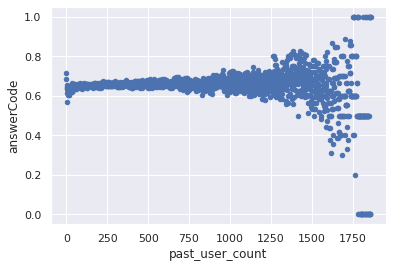

In [77]:
user_groupby.plot.scatter(x='past_user_count', y='answerCode')

In [78]:
# 카테고리화
df2['average_user_correct_cate'] = df2['average_user_correct'].transform(lambda x: math.floor(x*10))
df2[['average_user_correct','average_user_correct_cate']]

,average_user_correct,average_user_correct_cate
0,0.000000,0
1,1.000000,10
2,1.000000,10
3,1.000000,10
4,1.000000,10
...,...,...
2526695,0.538462,5
2526696,0.537600,5
2526697,0.538339,5
2526698,0.537480,5


In [79]:
# 이동평균(추세)
df2['shift'] = df_user.shift().fillna(0)
df2['moving_average_user_correct_10'] = df2['shift'].rolling(10).mean().fillna(0)
df2['moving_average_user_correct_5'] = df2['shift'].rolling(5).mean().fillna(0)
df2 = df2.drop(columns='shift')
df2[df2['userID']==0][['answerCode', 'moving_average_user_correct_5']].head(30)

,answerCode,moving_average_user_correct_5
267671,1,0.8
267672,1,0.8
267675,1,0.8
267678,1,1.0
267681,1,1.0
267685,1,1.0
289272,0,0.8
289274,1,0.6
289294,1,1.0
289300,1,0.4


In [80]:
moving_user_groupby = df2.groupby('moving_average_user_correct_5').agg({
    'answerCode': percentile
})
moving_user_groupby.index.name = 'moving_average_user_correct_5'
moving_user_groupby.reset_index(inplace=True)
moving_user_groupby.describe()

,moving_average_user_correct_5,answerCode
count,6.000000,6.000000
mean,0.500000,0.562889
std,0.374166,0.204854
min,0.000000,0.271158
25%,0.250000,0.424663
50%,0.500000,0.590400
75%,0.750000,0.716232
max,1.000000,0.797782


In [81]:
moving_user_groupby

,moving_average_user_correct_5,answerCode
0,0.0,0.271158
1,0.2,0.389832
2,0.4,0.529157
3,0.6,0.651644
4,0.8,0.737762
5,1.0,0.797782


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


<AxesSubplot:xlabel='moving_average_user_correct_5', ylabel='answerCode'>

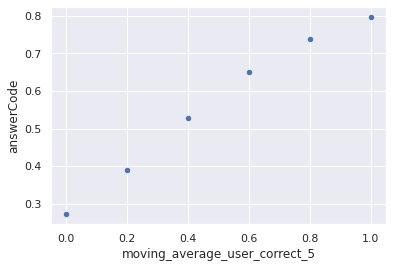

In [82]:
moving_user_groupby.plot.scatter(x='moving_average_user_correct_5', y='answerCode')

## 사용자 + 문항별

In [83]:
df_user_prob = df2.groupby(['userID','assessmentItemID'])['answerCode']

# 과거에 해당 문제를 푼 수
df2['past_user_prob_count'] = df_user_prob.cumcount()

# 과거에 해당 문제를 맞춘 횟수
df2['shift'] = df_user_prob.shift().fillna(0)
df2['past_user_prob_correct'] = df2.groupby(['userID', 'assessmentItemID'])['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 해당 문제 평균 정답률
df2['average_user_prob_correct'] = (df2['past_user_prob_correct'] / df2['past_user_prob_count']).fillna(0)

In [84]:
user_prob_groupby = df2.groupby('past_user_prob_count').agg({
    'userID': 'count',
    'answerCode': percentile
})
user_prob_groupby.index.name = 'past_user_prob_count'
user_prob_groupby.reset_index(inplace=True)
user_prob_groupby

,past_user_prob_count,userID,answerCode
0,0,2476706,0.654363
1,1,49100,0.647088
2,2,894,0.454139


<AxesSubplot:ylabel='userID'>

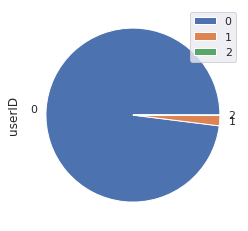

In [85]:
user_prob_groupby.plot.pie(x='past_user_prob_count', y='userID')

## 사용자 + 시험지별

In [86]:
df_user_test = df2.groupby(['userID','testId'])['answerCode']

# 과거에 해당 시험지를 푼 수
df2['past_user_test_count'] = df_user_test.cumcount()

# 과거에 해당 시험지를 맞춘 횟수
df2['shift'] = df_user_test.shift().fillna(0)
df2['past_user_test_correct'] = df2.groupby(['userID', 'testId'])['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 해당 시험지 평균 정답률
df2['average_user_test_correct'] = (df2['past_user_test_correct'] / df2['past_user_test_count']).fillna(0)

In [87]:
user_test_groupby = df2.groupby('past_user_test_count').agg({
    'userID': 'count',
    'answerCode': percentile
})
user_test_groupby.index.name = 'past_user_test_count'
user_test_groupby.reset_index(inplace=True)
user_test_groupby

,past_user_test_count,userID,answerCode
0,0,407189,0.750863
1,1,407189,0.721446
2,2,406901,0.690455
3,3,405125,0.662892
4,4,391445,0.598122
5,5,219828,0.557677
6,6,142792,0.518208
7,7,79233,0.468353
8,8,27039,0.528163
9,9,13399,0.580416


## 사용자 + 태그별

In [88]:
df_user_tag = df2.groupby(['userID','KnowledgeTag'])['answerCode']

# 과거에 해당 태그를 푼 수
df2['past_user_tag_count'] = df_user_tag.cumcount()

# 과거에 해당 태그를 맞춘 횟수
df2['shift'] = df_user_tag.shift().fillna(0)
df2['past_user_tag_correct'] = df2.groupby(['userID', 'KnowledgeTag'])['shift'].cumsum()
df2 = df2.drop(columns='shift')

# 과거 해당 태그 평균 정답률
df2['average_user_tag_correct'] = (df2['past_user_tag_correct'] / df2['past_user_tag_count']).fillna(0)

In [89]:
user_tag_groupby = df2.groupby('past_user_tag_count').agg({
    'userID': 'count',
    'answerCode': percentile
})
user_tag_groupby.index.name = 'past_user_tag_count'
user_tag_groupby.reset_index(inplace=True)
user_tag_groupby

,past_user_tag_count,userID,answerCode
0,0,492354,0.687444
1,1,422906,0.669106
2,2,367129,0.650831
3,3,315447,0.643243
4,4,269447,0.599376
...,...,...,...
103,103,1,1.000000
104,104,1,1.000000
105,105,1,0.000000
106,106,1,0.000000


# CSV 파일 저장

In [90]:
df2.dtypes

userID                                     int64
assessmentItemID                          object
testId                                    object
answerCode                                 int64
Timestamp                         datetime64[ns]
KnowledgeTag                               int64
Category                                   int64
Number                                    object
item                                       int64
item_order                                 int64
test_size                                  int64
retest                                     int64
user_test_ans_cnt                          int64
isTest                                     int64
Time                                       int64
elapsed_time                             float64
prob_mean_time                           float64
user_time_sum                            float64
user_time_mean                           float64
user_test_time_sum                       float64
moving_average_time 

In [91]:
df2

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,784,A060014001,A060000014,1,2019-12-31 15:08:01,7229,6,A014001,0,0,...,0.0,0,0.0,0.0,0,0.0,0.000000,0,0.0,0.00
1,784,A060014002,A060000014,1,2019-12-31 15:08:21,7229,6,A014002,1,1,...,0.0,0,0.0,0.0,1,1.0,1.000000,1,1.0,1.00
2,784,A060014003,A060000014,1,2019-12-31 15:08:55,7229,6,A014003,2,2,...,0.0,0,0.0,0.0,2,2.0,1.000000,2,2.0,1.00
3,784,A060014004,A060000014,1,2019-12-31 15:09:13,7229,6,A014004,3,3,...,0.0,0,0.0,0.0,3,3.0,1.000000,3,3.0,1.00
4,784,A060014005,A060000014,0,2019-12-31 15:09:29,7229,6,A014005,4,4,...,0.8,0,0.0,0.0,4,4.0,1.000000,4,4.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,588,A070152004,A070000152,0,2020-12-29 16:46:08,7866,7,A152004,3,3,...,0.2,0,0.0,0.0,3,1.0,0.333333,0,0.0,0.00
2526696,588,A070152005,A070000152,1,2020-12-29 16:46:13,3288,7,A152005,4,4,...,0.2,0,0.0,0.0,4,1.0,0.250000,1,0.0,0.00
2526697,588,A070152006,A070000152,0,2020-12-29 16:46:15,9078,7,A152006,5,5,...,0.4,0,0.0,0.0,5,2.0,0.400000,5,4.0,0.80
2526698,588,A070152007,A070000152,0,2020-12-29 16:46:18,9080,7,A152007,6,6,...,0.4,0,0.0,0.0,6,2.0,0.333333,8,6.0,0.75


In [92]:
df2 = df2.sort_values(by=['isTest', 'userID', 'Timestamp']).reset_index(drop=True)

In [93]:
df_new = df2
df_train_new = df_new[df_new['isTest'] == 0]
df_test_new = df_new[df_new['isTest'] == 1]

In [94]:
df_train_new

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,0,0,...,0.8,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1,1,...,0.8,0,0.0,0.0,1,1.0,1.00,0,0.0,0.00
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,2,2,...,0.8,0,0.0,0.0,2,2.0,1.00,1,1.0,1.00
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,3,3,...,1.0,0,0.0,0.0,3,3.0,1.00,2,2.0,1.00
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,4,4,...,1.0,0,0.0,0.0,4,4.0,1.00,3,3.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,A030071005,A030000071,0,2020-06-05 06:50:21,438,3,A071005,4,4,...,0.6,0,0.0,0.0,4,1.0,0.25,4,1.0,0.25
2266582,7441,A040165001,A040000165,1,2020-08-21 01:06:39,8836,4,A165001,0,0,...,0.4,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
2266583,7441,A040165002,A040000165,1,2020-08-21 01:06:50,8836,4,A165002,1,1,...,0.6,0,0.0,0.0,1,1.0,1.00,1,1.0,1.00
2266584,7441,A040165003,A040000165,1,2020-08-21 01:07:36,8836,4,A165003,2,2,...,0.6,0,0.0,0.0,2,2.0,1.00,2,2.0,1.00


In [95]:
df_test_new

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
2266586,3,A050023001,A050000023,1,2020-01-09 10:56:31,2626,5,A023001,0,0,...,0.4,0,0.0,0.0,0,0.0,0.000000,0,0.0,0.0
2266587,3,A050023002,A050000023,1,2020-01-09 10:56:57,2626,5,A023002,1,1,...,0.8,0,0.0,0.0,1,1.0,1.000000,1,1.0,1.0
2266588,3,A050023003,A050000023,0,2020-01-09 10:58:31,2625,5,A023003,2,2,...,0.8,0,0.0,0.0,2,2.0,1.000000,0,0.0,0.0
2266589,3,A050023004,A050000023,0,2020-01-09 10:58:36,2625,5,A023004,3,3,...,0.6,0,0.0,0.0,3,2.0,0.666667,1,0.0,0.0
2266590,3,A050023006,A050000023,0,2020-01-09 10:58:43,2623,5,A023006,5,5,...,0.6,0,0.0,0.0,4,2.0,0.500000,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2526695,7439,A040130001,A040000130,0,2020-10-14 23:07:23,8832,4,A130001,0,0,...,0.8,0,0.0,0.0,0,0.0,0.000000,0,0.0,0.0
2526696,7439,A040130002,A040000130,1,2020-10-14 23:07:41,8832,4,A130002,1,1,...,0.6,0,0.0,0.0,1,0.0,0.000000,1,0.0,0.0
2526697,7439,A040130003,A040000130,1,2020-10-14 23:08:02,8244,4,A130003,2,2,...,0.8,0,0.0,0.0,2,1.0,0.500000,0,0.0,0.0
2526698,7439,A040130004,A040000130,1,2020-10-14 23:09:31,8244,4,A130004,3,3,...,0.6,0,0.0,0.0,3,2.0,0.666667,1,1.0,1.0


In [96]:
df_train_new.to_csv("/opt/ml/input/data/train_dataset/tuning_train_data_bm.csv", mode='w')
df_test_new.to_csv("/opt/ml/input/data/train_dataset/tuning_test_data_bm.csv", mode='w')

# Feature Selection

In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import statsmodels.api as sm;
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
%matplotlib inline

In [98]:
df_new = pd.read_csv('/opt/ml/input/data/train_dataset/tuning_train_data_bm.csv', index_col = 0)
df_new.head()

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,Category,Number,item,item_order,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,6,A001001,0,0,...,0.8,0,0.0,0.0,0,0.0,0.0,0,0.0,0.0
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,6,A001002,1,1,...,0.8,0,0.0,0.0,1,1.0,1.0,0,0.0,0.0
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,6,A001003,2,2,...,0.8,0,0.0,0.0,2,2.0,1.0,1,1.0,1.0
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,6,A001004,3,3,...,1.0,0,0.0,0.0,3,3.0,1.0,2,2.0,1.0
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,6,A001005,4,4,...,1.0,0,0.0,0.0,4,4.0,1.0,3,3.0,1.0


In [99]:
# 문자열 타입 & 필요없는 column drop
df_new = df_new.drop(columns=['assessmentItemID', 'testId', 'Timestamp', 'Number', 'isTest'])
df_new

,userID,answerCode,KnowledgeTag,Category,item,item_order,test_size,retest,user_test_ans_cnt,Time,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,1,7224,6,0,0,6,0,0,1585009031,...,0.8,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
1,0,1,7225,6,1,1,6,0,1,1585009034,...,0.8,0,0.0,0.0,1,1.0,1.00,0,0.0,0.00
2,0,1,7225,6,2,2,6,0,2,1585009042,...,0.8,0,0.0,0.0,2,2.0,1.00,1,1.0,1.00
3,0,1,7225,6,3,3,6,0,3,1585009049,...,1.0,0,0.0,0.0,3,3.0,1.00,2,2.0,1.00
4,0,1,7225,6,4,4,6,0,4,1585009056,...,1.0,0,0.0,0.0,4,4.0,1.00,3,3.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,0,438,3,4,4,5,0,4,1591339821,...,0.6,0,0.0,0.0,4,1.0,0.25,4,1.0,0.25
2266582,7441,1,8836,4,0,0,4,0,0,1597971999,...,0.4,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
2266583,7441,1,8836,4,1,1,4,0,1,1597972010,...,0.6,0,0.0,0.0,1,1.0,1.00,1,1.0,1.00
2266584,7441,1,8836,4,2,2,4,0,2,1597972056,...,0.6,0,0.0,0.0,2,2.0,1.00,2,2.0,1.00


## Correlation

In [100]:
corr = df_new.corr()
corr.style.background_gradient(cmap='coolwarm')

,userID,answerCode,KnowledgeTag,Category,item,item_order,test_size,retest,user_test_ans_cnt,Time,elapsed_time,prob_mean_time,user_time_sum,user_time_mean,user_test_time_sum,moving_average_time,hour,weekday,past_prob_count,past_prob_correct,average_prob_correct,prob_mean,prob_sum,prob_mean_cate,past_test_count,past_test_correct,average_test_correct,test_mean,test_sum,past_tag_count,past_tag_correct,average_tag_correct,tag_mean,tag_sum,past_user_count,past_user_correct,average_user_correct,average_user_correct_cate,moving_average_user_correct_10,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
userID,1.000000,-0.035235,-0.015064,-0.065891,-0.021852,-0.022368,-0.059114,-0.055051,-0.022368,0.126468,-0.000007,0.022069,-0.411046,-0.035750,-0.020520,0.000716,0.004288,-0.006477,0.080045,0.096495,0.039283,0.052678,0.032533,0.051999,0.048242,0.079263,0.052806,0.072016,0.002406,0.061919,0.069386,0.052719,0.068817,0.002227,-0.457448,-0.440139,-0.130881,-0.120485,-0.010860,-0.020471,-0.055051,-0.044331,-0.043616,-0.044494,-0.058561,-0.034785,-0.146839,-0.143149,-0.054388
answerCode,-0.035235,1.000000,0.012086,-0.201841,-0.165713,-0.166232,-0.133862,-0.004983,-0.168630,-0.036482,0.021364,-0.049613,0.059592,0.120962,0.005187,0.001567,0.005886,-0.021898,-0.052228,0.127613,0.379365,0.413354,0.332356,0.409026,-0.100696,0.002337,0.296278,0.302507,0.105170,0.021573,0.082372,0.285782,0.288721,0.162191,0.012336,0.079323,0.290078,0.287031,0.228730,0.271746,-0.004976,0.009079,0.009796,-0.154971,0.114325,0.258937,-0.017581,0.131991,0.252647
KnowledgeTag,-0.015064,0.012086,1.000000,-0.150631,0.012776,0.012306,-0.009111,-0.003072,0.011801,0.130494,-0.012533,-0.028247,0.063861,-0.031680,-0.017810,0.000879,-0.009568,-0.000431,0.019954,0.036517,0.022421,0.030037,0.080926,0.029797,0.009914,0.020877,0.040849,0.051153,0.057413,0.002524,0.032146,0.036652,0.042304,0.055972,0.091193,0.080306,0.010607,0.008702,-0.024281,-0.014066,-0.003070,-0.001608,-0.001214,0.008952,0.002144,0.010762,-0.001329,0.014204,-0.000128
Category,-0.065891,-0.201841,-0.150631,1.000000,0.236791,0.238361,0.629931,0.012922,0.238361,0.043472,-0.086462,-0.184720,-0.012037,-0.204082,0.018608,-0.002346,0.041622,0.094864,-0.024884,-0.242856,-0.420866,-0.486463,-0.509979,-0.481501,0.208755,-0.023815,-0.596347,-0.664429,-0.099958,-0.235812,-0.366409,-0.629713,-0.695505,-0.569969,0.078327,0.010960,-0.252662,-0.251130,-0.226180,-0.219751,0.012922,-0.005583,-0.007335,0.228406,0.035200,-0.155360,-0.062931,-0.166416,-0.230723
item,-0.021852,-0.165713,0.012776,0.236791,1.000000,0.999134,0.375259,0.003482,0.967854,0.010575,0.115307,0.249242,0.001786,-0.062962,0.308765,-0.000963,0.016867,0.026261,-0.012498,-0.176510,-0.370268,-0.400008,-0.357200,-0.395337,0.120121,0.067033,-0.148704,-0.165170,0.133151,-0.039256,-0.077861,-0.200114,-0.212490,-0.120937,0.029625,0.012494,-0.049595,-0.051333,-0.100046,-0.102244,0.003458,-0.010230,-0.010610,0.874509,0.665246,0.274842,0.289182,0.223986,0.185689
item_order,-0.022368,-0.166232,0.012306,0.238361,0.999134,1.000000,0.378392,0.003654,0.968807,0.010857,0.114595,0.247704,0.002000,-0.063500,0.308486,-0.001061,0.016904,0.026398,-0.011295,-0.175886,-0.371185,-0.401244,-0.356137,-0.396665,0.122074,0.068608,-0.150462,-0.167244,0.136479,-0.039205,-0.078198,-0.201678,-0.214156,-0.122066,0.030043,0.012759,-0.050315,-0.052040,-0.100607,-0.102849,0.003630,-0.010113,-0.010496,0.875462,0.665569,0.274158,0.288589,0.223065,0.184827
test_size,-0.059114,-0.133862,-0.009111,0.629931,0.375259,0.378392,1.000000,0.009593,0.378392,0.028588,-0.084302,-0.181443,-0.003870,-0.156039,0.057176,-0.002922,0.042329,0.069388,-0.029847,-0.168263,-0.288101,-0.323607,-0.347205,-0.318093,0.315318,0.173638,-0.408027,-0.441987,0.360681,-0.138401,-0.223051,-0.420875,-0.456375,-0.346812,0.063599,0.019655,-0.166693,-0.1660

## OLS

In [101]:
lm = sm.OLS(df_new['answerCode'], df_new.astype(float))
results = lm.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             answerCode   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 2.770e+17
Date:                Sat, 12 Jun 2021   Prob (F-statistic):               0.00
Time:                        15:49:43   Log-Likelihood:             3.1788e+07
No. Observations:             2266586   AIC:                        -6.358e+07
Df Residuals:                 2266537   BIC:                        -6.357e+07
Df Model:                          48                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
userID                         -2.079e-11   9.66e-14   -215.264      0.000    -2.1e-11   -2.06e-11
answerCode                         1.0000   3.26e-10   3.07e+09      0.000       1.000       1.000
KnowledgeTag                   -1.838e-11   4.17e-14   -441.019      0.000   -1.85e-11   -1.83e-11
Category                       -1.479e-09   9.69e-11    -15.263      0.000   -1.67e-09   -1.29e-09
item                            1.719e-08   1.56e-09     11.042      0.000    1.41e-08    2.02e-08
item_order                     -2.312e-08   1.58e-09    -14.609      0.000   -2.62e-08      -2e-08
test_size                       9.399e-09   3.04e-10     30.914      0.000     8.8e-09       1e-08
retest                         -1.096e-08   6.96e-08     -0.158      0.875   -1.47e-07    1.25e-07
user_test_ans_cnt              -8.813e-11   6.65e-10     -0.132      0.895   -1.39e-09    1.22e-09
Time                            1.931e-16   1.79e-18    107.759      0.000     1.9e-16    1.97e-16
elapsed_time                   -9.991e-15   7.03e-13     -0.014      0.989   -1.39e-12    1.37e-12
prob_mean_time                 -1.504e-14   1.38e-12     -0.011      0.991   -2.72e-12    2.69e-12
user_time_sum                  -7.391e-17   1.29e-14     -0.006      0.995   -2.53e-14    2.52e-14
user_time_mean                  2.604e-14   3.76e-12      0.007      0.994   -7.35e-12     7.4e-12
user_test_time_sum              1.565e-14   3.43e-13      0.046      0.964   -6.56e-13    6.87e-13
moving_average_time            -1.045e-15   8.51e-13     -0.001      0.999   -1.67e-12    1.67e-12
hour                           -1.269e-13    2.2e-11     -0.006      0.995   -4.33e-11    4.31e-11
weekday                         -8.55e-12   7.71e-11     -0.111      0.912    -1.6e-10    1.42e-10
past_prob_count                  -9.8e-13   1.03e-11     -0.095      0.924   -2.11e-11    1.92e-11
past_prob_correct               1.313e-13   1.09e-11      0.012      0.990   -2.13e-11    2.16e-11
average_prob_correct           -7.649e-12   1.97e-09     -0.004      0.997   -3.87e-09    3.86e-09
prob_mean                      -8.889e-12   5.76e-09     -0.002      0.999   -1.13e-08    1.13e-08
prob_sum                         2.56e-12   1.05e-11      0.244      0.807    -1.8e-11    2.31e-11
prob_mean_cate                 -8.091e-11   4.57e-10     -0.177      0.860   -9.77e-10    8.15e-10
past_test_count                -1.397e-13   1.57e-12     -0.089      0.929   -3.22e-12    2.94e-12
past_test_correct               4.581e-13   2.42e-12      0.189      0.850   -4.29e-12    5.21e-12
average_test_correct           -4.649e-12   3.71e-09     -0.001      0.999   -7.27e-09    7.26e-09
test_mean                      -6.413e-12   4.89e-09     -0.001      0.999   -9.58e-09    9.57e-09
test_sum      

## Feature Importance

In [102]:
X_train, y_train = df_new.loc[:,df_new.columns!='answerCode'], df_new['answerCode']

In [103]:
X_train

,userID,KnowledgeTag,Category,item,item_order,test_size,retest,user_test_ans_cnt,Time,elapsed_time,...,moving_average_user_correct_5,past_user_prob_count,past_user_prob_correct,average_user_prob_correct,past_user_test_count,past_user_test_correct,average_user_test_correct,past_user_tag_count,past_user_tag_correct,average_user_tag_correct
0,0,7224,6,0,0,6,0,0,1585009031,3.0,...,0.8,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
1,0,7225,6,1,1,6,0,1,1585009034,8.0,...,0.8,0,0.0,0.0,1,1.0,1.00,0,0.0,0.00
2,0,7225,6,2,2,6,0,2,1585009042,7.0,...,0.8,0,0.0,0.0,2,2.0,1.00,1,1.0,1.00
3,0,7225,6,3,3,6,0,3,1585009049,7.0,...,1.0,0,0.0,0.0,3,3.0,1.00,2,2.0,1.00
4,0,7225,6,4,4,6,0,4,1585009056,11.0,...,1.0,0,0.0,0.0,4,4.0,1.00,3,3.0,1.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266581,7441,438,3,4,4,5,0,4,1591339821,401.0,...,0.6,0,0.0,0.0,4,1.0,0.25,4,1.0,0.25
2266582,7441,8836,4,0,0,4,0,0,1597971999,11.0,...,0.4,0,0.0,0.0,0,0.0,0.00,0,0.0,0.00
2266583,7441,8836,4,1,1,4,0,1,1597972010,46.0,...,0.6,0,0.0,0.0,1,1.0,1.00,1,1.0,1.00
2266584,7441,8836,4,2,2,4,0,2,1597972056,73.0,...,0.6,0,0.0,0.0,2,2.0,1.00,2,2.0,1.00


In [104]:
y_train

0          1
1          1
2          1
3          1
4          1
          ..
2266581    0
2266582    1
2266583    1
2266584    1
2266585    1
Name: answerCode, Length: 2266586, dtype: int64

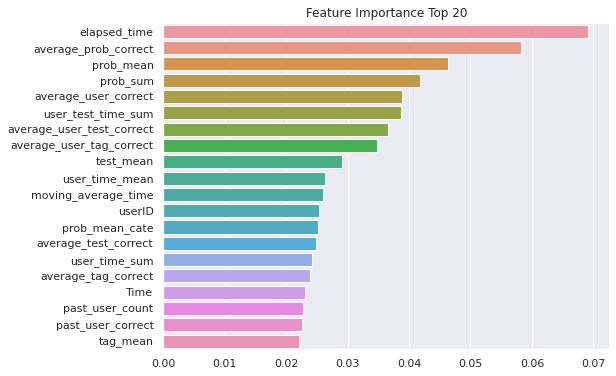

In [105]:
forest = RandomForestClassifier(n_estimators=5, n_jobs=-1, random_state=42) # n_estimators: 사용할 tree수
forest.fit(X_train, y_train)

# 배열형태로 반환
ft_importance_values = forest.feature_importances_

# 정렬과 시각화를 쉽게 하기 위해 series 전환
ft_series = pd.Series(ft_importance_values, index = X_train.columns)
ft_top20 = ft_series.sort_values(ascending=False)[:20]

# 시각화
plt.figure(figsize=(8,6))
plt.title('Feature Importance Top 20')
sns.barplot(x=ft_top20, y=ft_top20.index)
plt.show()

In [106]:
lgb_data = lgb.Dataset(X_train, y_train)
model = lgb.train(
                    {'objective': 'binary'}, 
                    lgb_data,
                    valid_sets=lgb_data,
                    verbose_eval=100,
                    num_boost_round=500,
                    early_stopping_rounds=100
                )

[LightGBM] [Info] Number of positive: 1483205, number of negative: 783381
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.149771 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7372
[LightGBM] [Info] Number of data points in the train set: 2266586, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.654378 -> initscore=0.638341
[LightGBM] [Info] Start training from score 0.638341
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.449743
[200]	training's binary_logloss: 0.445923
[300]	training's binary_logloss: 0.443558
[400]	training's binary_logloss: 0.441621
[500]	training's binary_logloss: 0.439909
Did not meet early stopping. Best iteration is:
[500]	training's binary_logloss: 0.439909


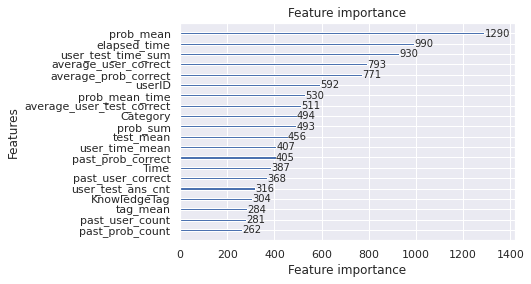

In [107]:
_ = lgb.plot_importance(model, max_num_features=20)